In [1]:
import glob

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import G23

from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

## User set infomation

In [2]:
file_path = "/home/kgordon/Python/extstar_data/"

starnames = ["2massj150958"]

relband = "V"
velocity = 0.0

## Useful functions

In [37]:
def plot_data_model(reddened_star, modinfo, params,
                    xrange=None, yrange=None, title=None):

    # intrinsic sed
    modsed = modinfo.stellar_sed(params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    #modsed_stardata = modinfo.SED_to_StarData(modsed)

    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes).value

    # plotting setup for easier to read plots
    fontsize = 18
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 10))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        gvals = reddened_star.data[cspec].npts > 0
        ax.plot(
            reddened_star.data[cspec].waves[gvals],
            reddened_star.data[cspec].fluxes[gvals],
            "k" + ptype,
            label="data",
        )
        
        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        ax.plot(
            modinfo.waves[cspec], modsed[cspec] * norm_data / norm_model, "b" + ptype, label=cspec
        )
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] * norm_data / norm_model,
            "r" + ptype,
            label=cspec,
        )
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] * norm_data / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
    if xrange is not None:
        ax.set_xlim(xrange)
    if yrange is not None:
        ax.set_ylim(yrange)
    else:
        ax.set_ylim(1 * norm_data / norm_model, 8e9 * norm_data / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    ax.set_title(title)
    
    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    

def plot_ext(extdata):
    fontsize = 18
    
    fig, tax = plt.subplots(ncols=2, figsize=(18, 8))

    # if extdata.type == "elx":
    #    extdata.trans_elv_alav()

    ax = tax[0]
    extdata.plot(ax) #, alax=True)
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    # ax.set_ylim(0.004, 10.0)
    ax.set_ylabel(r"$E(\lambda - V)$", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")
    
    # plot known exitnction curves
    mod_x = np.arange(0.033, 10.5, 0.001) / u.micron
    av = extdata.columns["AV"][0]
    rv = extdata.columns["RV"][0]
    g23_rv31 = G23(Rv=rv)
    ax.plot(1.0 / mod_x, (g23_rv31(mod_x) - 1.) * av, "k-", label=f"G23 R(V) = {rv}")
    ax.set_xscale("log")
    
    ax = tax[1]
    extdata.plot(ax) 
    ax.plot(1.0 / mod_x, (g23_rv31(mod_x) - 1.) * av, "k-")
    ax.set_xlim(2.3, 20.)
    ax.set_ylim(-1.05*av, -0.9*av)
    
    ax.set_xscale("log")
    

def get_instrinsic_sed(fit_params, modinfo, reddened_star, starname, rel_band):
    # intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=0.0)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save(starname + "_ext.fits", column_info=col_info)
    
    return extdata


def calc_ext(reddened_star, modinfo, fit_params, velocity, relband):
    # intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)
    
    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.columns = {"AV": (fit_params[3], 0.0), "RV": (fit_params[4], 0.0)}
    extdata.save(starname + "_ext.fits", column_info=col_info)
    
    return(extdata)

In [4]:
def get_tlusty_models(file_path, band_names, data_names):

    tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v5.dat".format(file_path))
    tlusty_models = [
        tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
    ]
    
    # get the models with just the reddened star band data and spectra
    modinfo = ModelData(
        tlusty_models,
        path="{}/Models/".format(file_path),
        band_names=band_names,
        spectra_names=data_names,
    )

    return modinfo
        

# get the observed reddened star data
def setup_parameters(modinfo):

    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # initial starting position
    #  **customize for each star**
    params = [4.3, 4.0, 0.0, 4.5, 3.1, 1.0, 3.0, 0.1, 4.66, 0.86, 10.5, 19.0]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 10.0],   # Av
            [2.31, 5.59],   # Rv
            [-0.1, 5.0],  # C2
            [0.0, 5.0],   # C3
            [0.0, 1.0],   # C4
            [4.5, 4.9],   # xo
            [0.6, 1.5],   # gamma
            [10.0, 11.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    ppriors = {}
    #ppriors["logT"] = (params[0], 0.01)
    #ppriors["logg"] = (3.1, 0.1)
    ppriors["logZ"] = (-0.1, 0.1)

    return pnames, params, plimits, ppriors


def get_weights(reddened_star):

    # cropping info for weights
    #  bad regions are defined as those were we know the models do not work
    #  or the data is bad
    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
    ] / u.micron

    weights = {}
    for cspec in reddened_star.data.keys():
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0

        weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
    #weights["BAND"] *= 10000.0
    
    return weights

In [10]:
def run_mcmc(params, fitinfo, reddened_star, modinfo):
    p0 = params
    ndim = len(p0)

    #nwalkers = 2 * ndim
    #nsteps = 50
    #burn = 50

    nwalkers = 100
    nsteps = 500
    burn = 500

    # setting up the walkers to start "near" the inital guess
    p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

    # setup the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo, fitinfo)
    )

    # burn in the walkers
    pos, prob, state = sampler.run_mcmc(p, burn)

    # rest the sampler
    sampler.reset()

    # do the full sampling
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

    # create the samples variable for later use
    samples = sampler.chain.reshape((-1, ndim))

    # get the best fit values
    pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
    params_best = get_best_fit_params(sampler)
    fit_params = params_best
    print("best params")
    print(params_best)

    # get the 16, 50, and 84 percentiles
    params_per = get_percentile_params(samples)

    # save the best fit and p50 +/- uncs values to a file
    # save as a single row table to provide a uniform format
    #f = open(out_basename + "_fit_params.dat", "w")
    #f.write("# best fit, p50, +unc, -unc\n")
    for k, val in enumerate(params_per):
        print(
            "{} {} {} {} # {}".format(
                params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
    #    f.write(
    #        "{} {} {} {} # {}\n".format(
    #            params_best[k], val[0], val[1], val[2], pnames_extra[k]
    #        )
    #    )

    
    return params_best, params_per, pnames_extra

## Fit each star

In [5]:
modinfo = None
orig_band_names = None

working on 2massj150958
-285070890.1878422 -0.5 -285070890.6878422


/tmp/ipykernel_3366/3079628930.py:81: RuntimeWarning: divide by zero encountered in true_divide
  weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value


Optimization terminated successfully.
minimizer results
4.176091259092933 # logT
3.80063612164946 # logg
-0.0009904499538670318 # logZ
4.524381778574485 # Av
3.378611946982985 # Rv
1.1718256919696257 # C2
2.9707344723506566 # C3
0.10467619553385421 # C4
4.521281978206262 # x0
0.7065670296774833 # gamma
10.656858575363628 # HI_gal
21.907287422778182 # HI_mw


/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


best params
[ 4.17610395e+00  3.00027183e+00 -1.21775666e-03  4.44149310e+00
  3.36366070e+00  1.32274409e+00  1.48535700e+00  1.66058927e-01
  4.56099721e+00  6.13194207e-01  1.08440432e+01  1.82198662e+01
  1.32043434e+00  1.57222317e+10  5.28842528e+10]
4.176103954992566 4.176181387294389 0.0012316461437347215 0.02500708733655177 # logT
3.0002718299280673 3.0003973774429906 0.7633203282977603 0.0005939461889696851 # logg
-0.0012177566638857614 -0.001087271893122506 8.809577839573985e-05 0.00010515173937226995 # logZ
4.441493100438186 4.442501307248177 0.049261688498304146 0.0006045825148444095 # Av
3.3636606977228225 3.3752217354478096 0.011941896995294687 0.005594282785150284 # Rv
1.3227440931641674 1.3098856423521699 0.05381559435887051 0.12193239176607706 # C2
1.4853570035825383 2.353795084061737 0.5778101153823942 0.6693151516389237 # C3
0.16605892713889728 0.12742445997929566 0.02136089753982856 0.02219261469157051 # C4
4.560997214722241 4.701863853080927 0.06162235581380582 0.

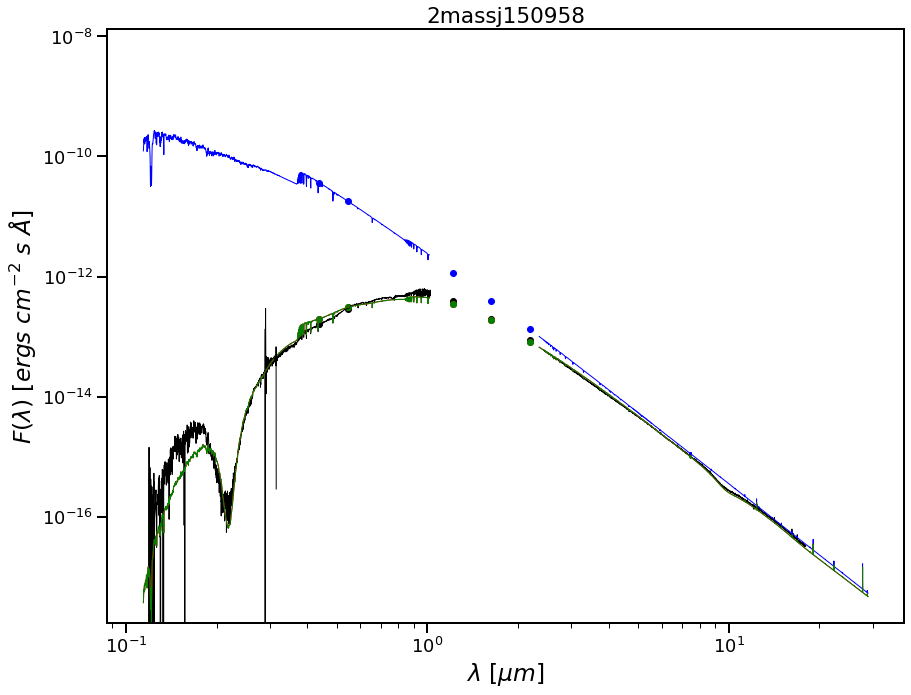

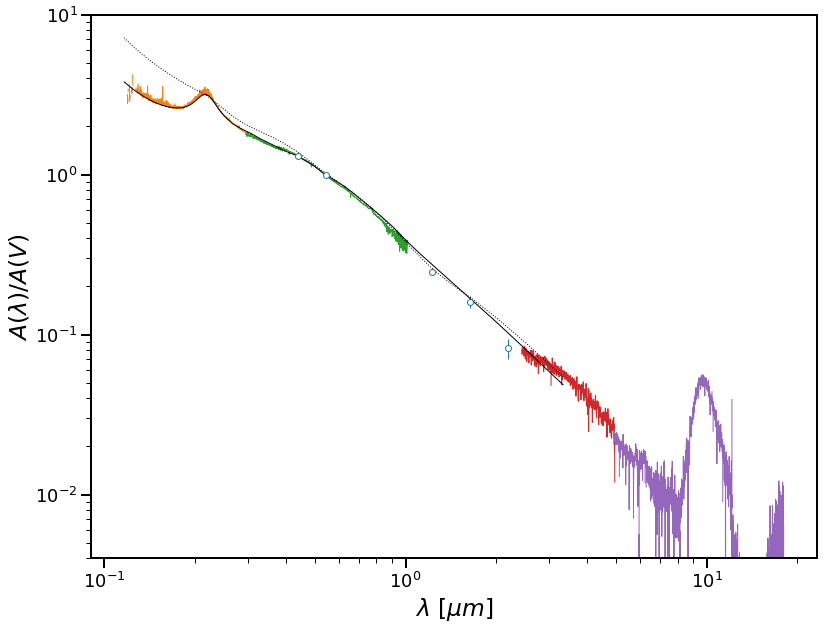

In [12]:
for starname in starnames:
    print(f"working on {starname}")
    reddened_star = StarData(f"{starname}.dat", path=f"{file_path}/DAT_files/", only_bands=orig_band_names)

    # temp fix until IUE data mocked
    if "IUE" in reddened_star.data.keys():
        reddened_star.data["STIS"] = reddened_star.data["IUE"]
        del reddened_star.data["IUE"]
    
    # remove
    bvals = reddened_star.data["MIRI_IFU"].waves > 18.0 * u.micron
    reddened_star.data["MIRI_IFU"].npts[bvals] = 0

    
    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()
    
    if modinfo is None:
        orig_band_names = band_names
        orig_data_names = data_names
        modinfo = get_tlusty_models(file_path, band_names, data_names)
 
    pnames, params, plimits, ppriors = setup_parameters(modinfo)
    
    # initial guess
    # plot_data_model(reddened_star, modinfo, params, title=f"{starname} (initial)")
    
    weights = get_weights(reddened_star)
    
    # package for passing to fitter
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    
    # check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
    # will state if param is outside limits
    fitinfo.check_param_limits(params)
    # all should be zero or negative
    print(fitinfo.lnlike(params, reddened_star, modinfo),
          fitinfo.lnprior(params),
          fitinfo.lnprob(params, reddened_star, modinfo, fitinfo))
    
    
    # simple function to turn the log(likelihood) into the chisqr
    #  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
    def nll(*args):
        return -fitinfo.lnprob(*args)

    # run the fit
    result = op.minimize(
        nll, params, method="Nelder-Mead", options={"maxiter": 5000}, args=(reddened_star, modinfo, fitinfo)
    )

    # check the fit output
    print(result["message"])

    params = result["x"]
    
    # print the best fit
    print("minimizer results")
    for k, val in enumerate(params):
        print("{} # {}".format(val, pnames[k]))
        
    do_mcmc = True
    if do_mcmc:
        params_best, params_per, pnames_extra = run_mcmc(params, fitinfo, reddened_star, modinfo)
        params = params_best
        
    plot_data_model(reddened_star, modinfo, params, title=starname)
    
    extdata = calc_ext(reddened_star, modinfo, params, velocity, relband)
    plot_ext(extdata)

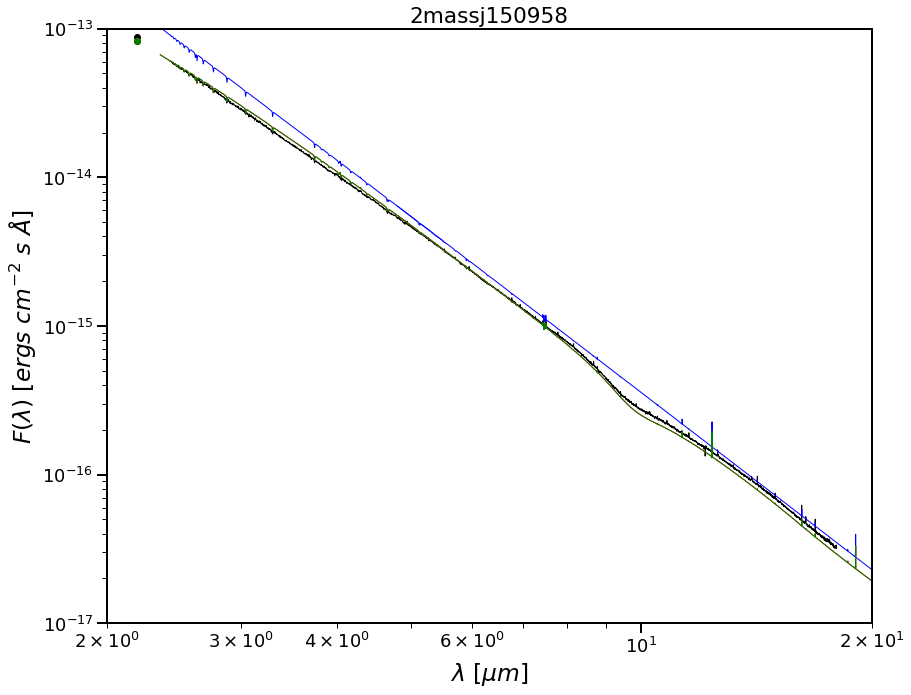

In [7]:
plot_data_model(reddened_star, modinfo, result["x"], title=starname, xrange=[2.0, 20.], yrange=[1e-17, 1e-13])

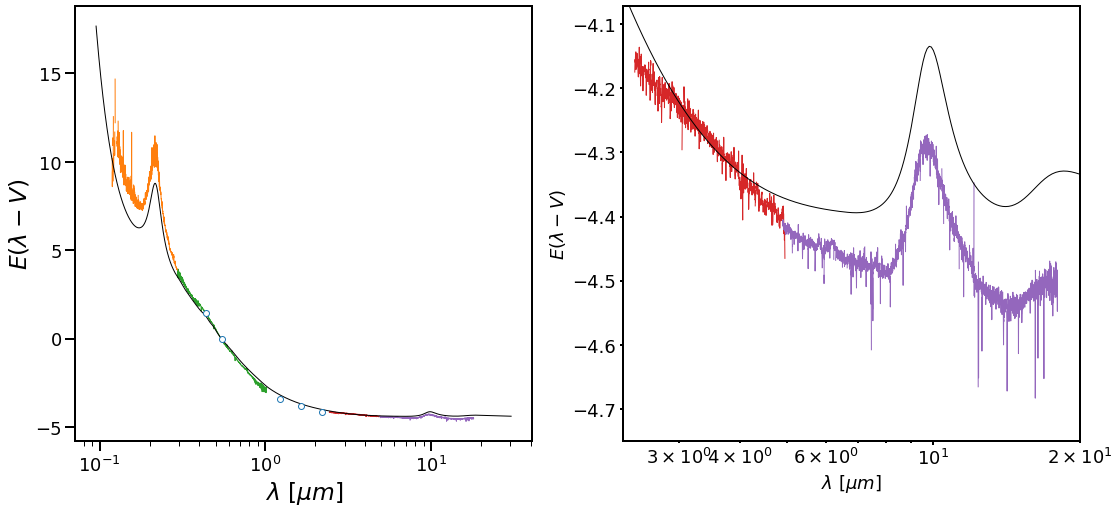

In [36]:
def plot_ext(extdata):
    fontsize = 18
    
    fig, tax = plt.subplots(ncols=2, figsize=(18, 8))

    # if extdata.type == "elx":
    #    extdata.trans_elv_alav()

    ax = tax[0]
    extdata.plot(ax) #, alax=True)
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    # ax.set_ylim(0.004, 10.0)
    ax.set_ylabel(r"$E(\lambda - V)$", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")
    
    # plot known exitnction curves
    mod_x = np.arange(0.033, 10.5, 0.001) / u.micron
    av = extdata.columns["AV"][0]
    rv = extdata.columns["RV"][0]
    g23_rv31 = G23(Rv=rv)
    ax.plot(1.0 / mod_x, (g23_rv31(mod_x) - 1.) * av, "k-", label=f"G23 R(V) = {rv}")
    ax.set_xscale("log")
    
    ax = tax[1]
    extdata.plot(ax) 
    ax.plot(1.0 / mod_x, (g23_rv31(mod_x) - 1.) * av, "k-")
    ax.set_xlim(2.3, 20.)
    ax.set_ylim(-1.05*av, -0.9*av)
    
    ax.set_xscale("log")
    # ax.set_yscale("log")

extdata = calc_ext(reddened_star, modinfo, fit_params, velocity, relband)
plot_ext(extdata)